In [1]:
import os, shutil

In [2]:
base_dir = '/home/skhatter/Damage Detection'
train_dir = '/home/skhatter/Damage Detection/train'
valid_dir = '/home/skhatter/Damage Detection/validation'
test_dir = '/home/skhatter/Damage Detection/test'

train_dam_dir = '/home/skhatter/Damage Detection/train/damaged'
train_undam_dir = '/home/skhatter/Damage Detection/train/undamaged'

valid_dam_dir = '/home/skhatter/Damage Detection/validation/damaged'
valid_undam_dir = '/home/skhatter/Damage Detection/validation/undamaged'

test_dir = '/home/skhatter/Damage Detection/test'

In [3]:
print('Total training damaged images', len(os.listdir(train_dam_dir)))
print('Total training undamaged images', len(os.listdir(train_undam_dir)))

print('Total validation damaged images', len(os.listdir(valid_dam_dir)))
print('Total validation undamaged images', len(os.listdir(valid_undam_dir)))

print('Total test damaged images', len(os.listdir(test_dir)))

Total training damaged images 102
Total training undamaged images 141
Total validation damaged images 10
Total validation undamaged images 21
Total test damaged images 2


In [4]:
from keras.applications import VGG16

Using TensorFlow backend.


In [5]:
conv_base = VGG16(weights='imagenet', include_top=False, 
                  input_shape=(512,512,3))

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 48,269,633
Trainable params: 48,269,633
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('this is the number of trainable weights'
     'before freezing the conv base', len(model.trainable_weights))
#conv_base.trainable = False

#Fine tune the last 3 convolutional layers
#therefore all layers up until block4_pool are frozen

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
                


print('this is the number of trainable weights after'
      'freezing the conv base', len(model.trainable_weights))

this is the number of trainable weightsbefore freezing the conv base 30
this is the number of trainable weights afterfreezing the conv base 30


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=40, 
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(512,512),
                                                   batch_size=5,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(valid_dir,
                                                       target_size=(512,512),
                                                       batch_size=5,
                                                       class_mode='binary')

Found 243 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [10]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])


history = model.fit_generator(train_generator, 
                              steps_per_epoch=50,
                              epochs=50,  
                    validation_data=validation_generator,
                              validation_steps=25)

Epoch 1/50
50/50 [==============================] - 33s - loss: 6.6010 - acc: 0.5747 - val_loss: 1.5582 - val_acc: 0.6726
Epoch 2/50
50/50 [==============================] - 28s - loss: 6.9078 - acc: 0.5667 - val_loss: 1.5701 - val_acc: 0.6726
Epoch 3/50
50/50 [==============================] - 29s - loss: 6.5668 - acc: 0.5881 - val_loss: 1.4790 - val_acc: 0.6903
Epoch 4/50
50/50 [==============================] - 29s - loss: 6.6969 - acc: 0.5799 - val_loss: 1.5239 - val_acc: 0.6814
Epoch 5/50
50/50 [==============================] - 29s - loss: 6.7385 - acc: 0.5773 - val_loss: 1.5175 - val_acc: 0.6814
Epoch 6/50
50/50 [==============================] - 30s - loss: 6.7164 - acc: 0.5787 - val_loss: 1.4793 - val_acc: 0.6903
Epoch 7/50
50/50 [==============================] - 30s - loss: 6.5693 - acc: 0.5879 - val_loss: 1.5226 - val_acc: 0.6814
Epoch 8/50
50/50 [==============================] - 30s - loss: 6.9078 - acc: 0.5667 - val_loss: 1.4786 - val_acc: 0.6903
Epoch 9/50
50/50 [======

In [14]:
history_dict = history.history
print(history_dict.keys())

model.save('damage_undamaged_conv5_vgg.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [12]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

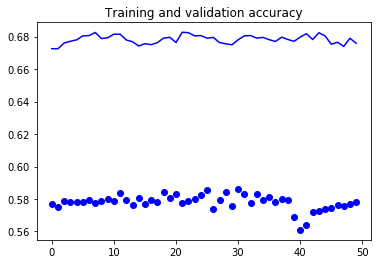

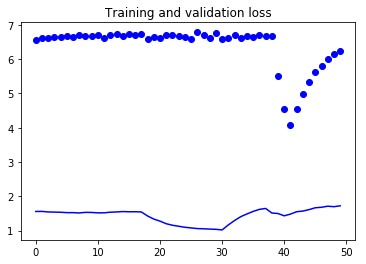

In [13]:
#Displaying curves of loss and accuracy during training 

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, smooth_curve(acc), 'bo')#dots
plt.plot(epochs, smooth_curve(val_acc), 'b')#line segments
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo')
plt.plot(epochs, smooth_curve(val_loss), 'b')
plt.title('Training and validation loss')
plt.show()

In [15]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=30,
                              epochs=50,  
                    validation_data=validation_generator,
                              validation_steps=25)

history_dict = history.history
print(history_dict.keys())

model.save('damage_undamaged_conv5_2_vgg.h5')

Epoch 1/50
30/30 [==============================] - 18s - loss: 6.1644 - acc: 0.6133 - val_loss: 1.8363 - val_acc: 0.6637
Epoch 2/50
30/30 [==============================] - 17s - loss: 6.5546 - acc: 0.5889 - val_loss: 1.7899 - val_acc: 0.6726
Epoch 3/50
30/30 [==============================] - 18s - loss: 6.7295 - acc: 0.5779 - val_loss: 1.7892 - val_acc: 0.6726
Epoch 4/50
30/30 [==============================] - 18s - loss: 6.5895 - acc: 0.5867 - val_loss: 1.7901 - val_acc: 0.6726
Epoch 5/50
30/30 [==============================] - 19s - loss: 6.6232 - acc: 0.5846 - val_loss: 1.5972 - val_acc: 0.7080
Epoch 6/50
30/30 [==============================] - 19s - loss: 6.5895 - acc: 0.5867 - val_loss: 1.7812 - val_acc: 0.6726
Epoch 7/50
30/30 [==============================] - 19s - loss: 7.0108 - acc: 0.5602 - val_loss: 1.8276 - val_acc: 0.6637
Epoch 8/50
30/30 [==============================] - 19s - loss: 6.4861 - acc: 0.5932 - val_loss: 1.7897 - val_acc: 0.6726
Epoch 9/50
30/30 [======

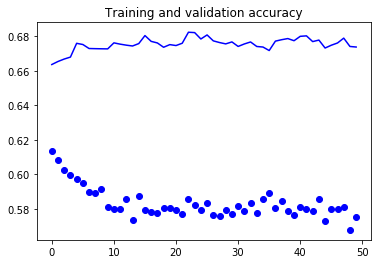

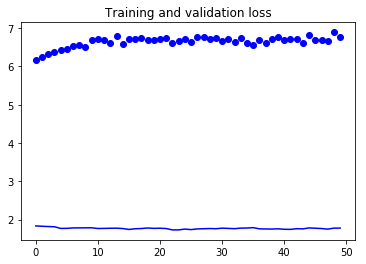

In [16]:
#Displaying curves of loss and accuracy during training 

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, smooth_curve(acc), 'bo')#dots
plt.plot(epochs, smooth_curve(val_acc), 'b')#line segments
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo')
plt.plot(epochs, smooth_curve(val_loss), 'b')
plt.title('Training and validation loss')
plt.show()